In [1]:
#default_exp discharge

# Battery Discharging

<br>

### Problem Definition


##### Cost Function

We'll start by defining the cost function for the demand forecasting component of the battery discharge optimisation.

For each day ($𝑑$ = 1, … , 7) the peak percentage reduction is calculated using:

$$R_{d, peak} = 100\left(\frac{\max_{k\in\{32,...,42\}}\left(L_{d, k}\right) - \max_{k\in\{32,...,42\}}\left(L_{d, k}+B_{d, k}\right)}{\max_{k\in\{32,...,42\}}\left(L_{d, k}\right)}\right)$$

Where:
* $L_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, where $k = 1$ would mean the period from midnight to 00:30 AM on the current day, $d$. 
* $B_{d, k}$ is the average power (in MW) over the $k^{th}$ half hour of day $d$, to minimise the peak demand over the evening period (the half hours $𝑘$ = 32 𝑡𝑜 42)

Our goal is to maximise the peak percentage reduction from 3.30PM to 9PM.

<br>

##### Constraints

We also have a number of constraints. The first constraint is on the maximum import and export of energy, in this case:

$$-2.5MW = B_{min} \leq B_{d, k} \leq B_{max} = 2.5MW$$

Secondly the battery cannot charge beyond its capacity, $C_{d, k}$, (in MWh):

$$0 \leq C_{d, k} \leq C_{max} = 6MWh$$

The total charge in the battery at the next time step $C_{d, k+1}$ is related to how much is currently in the battery and how much charged within the battery at time $k$, i.e.

$$C_{d, k+1} = C_{d, k} + 0.5B_{d, k}$$

Finally, the battery must start empty at the start of each day in the test week. I.e. $C_{d,1} = 0$ for $d = 1, … , 7$.

<br>

##### Output

The desired output from the battery discharging optimisation will be an array with 11 values, one for each settlement period. As the battery profile is expressed in terms of the charge all values within the evening time period should be 0 or negative. An example profile is shown below.

```python
battery_evening_profile = [
    0,  # 15:30 - 16:00
    0,  # 16:00 - 16:30
    0,  # 16:30 - 17:00
    0,  # 17:00 - 17:30
    -2, # 17:30 - 18:00
    -2, # 18:00 - 18:30
    -2, # 18:30 - 19:00
    -2, # 19:00 - 19:30
    -2, # 19:30 - 20:00
    0,  # 20:00 - 20:30
    0,  # 20:30 - 21:00
]
```

<br>

### Imports

In [2]:
#exports
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from skopt.plots import plot_objective
from skopt.space import Real, Categorical, Integer

from statsmodels.tsa.stattools import acf
from moepy.lowess import Lowess, quantile_model

from batopt import clean, utils

import os
import random
import joblib
from ipypb import track
import FEAutils as hlp

<br>

### User Inputs

In [3]:
raw_data_dir = '../data/raw'
intermediate_data_dir = '../data/intermediate'
cache_data_dir = '../data/nb-cache'
discharge_opt_model_fp = '../models/discharge_opt.sav'

<br>

### Preparing Data

We'll start by loading the datasets, we'll interpolate the weather data which is at an hourly granularity 

In [4]:
df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)

df.tail()

,demand,pv,weather,demand_MW,irradiance_Wm-2,panel_temp_C,pv_power_mw,solar_location1,solar_location2,solar_location3,solar_location4,solar_location5,solar_location6,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6
2018-07-29 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,16.125,16.370,15.485,16.285,17.625,17.415
2018-07-29 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,16.040,16.300,15.310,16.030,17.580,17.390
2018-07-29 22:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,15.980,16.255,15.215,15.835,17.570,17.380
2018-07-29 23:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,15.920,16.210,15.120,15.640,17.560,17.370
2018-07-29 23:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0,15.920,16.210,15.120,15.640,17.560,17.370


<br>

Next we'll construct our features dataframe

In [5]:
#exports
def construct_df_discharge_features(df, dt_rng=None):
    if dt_rng is None:
        dt_rng = pd.date_range(df.index.min(), df.index.max(), freq='30T')
        
    df_features = pd.DataFrame(index=dt_rng)
    
    # Filtering for the temperature weather data
    temp_loc_cols = df.columns[df.columns.str.contains('temp_location')]
    df_features.loc[df.index, temp_loc_cols] = df[temp_loc_cols].copy()
    df_features = df_features.ffill(limit=1)
    
    # Adding lagged demand
    df_features['demand_7d_lag'] = df['demand_MW'].shift(48*7)

    # Adding datetime features
    dts = df_features.index.tz_convert('Europe/London') # We want to use the 'behavioural' timezone

    df_features['weekend'] = dts.dayofweek.isin([5, 6]).astype(int)
    df_features['hour'] = dts.hour + dts.minute/60
    df_features['doy'] = dts.dayofyear
    df_features['dow'] = dts.dayofweek
    
    # Removing NaN values
    df_features = df_features.dropna()
    
    return df_features

In [6]:
df_features = construct_df_discharge_features(df)

df_features.tail()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,demand_7d_lag,weekend,hour,doy,dow
2018-07-29 21:30:00+00:00,16.125,16.370,15.485,16.285,17.625,17.415,2.40,1,22.5,210,6
2018-07-29 22:00:00+00:00,16.040,16.300,15.310,16.030,17.580,17.390,2.15,1,23.0,210,6
2018-07-29 22:30:00+00:00,15.980,16.255,15.215,15.835,17.570,17.380,1.93,1,23.5,210,6
2018-07-29 23:00:00+00:00,15.920,16.210,15.120,15.640,17.560,17.370,1.82,0,0.0,211,0
2018-07-29 23:30:00+00:00,15.920,16.210,15.120,15.640,17.560,17.370,1.63,0,0.5,211,0


<br>

We'll now create demand and features time-series with the same date indexes

In [7]:
dt_idx = pd.date_range(df_features.index.min(), df['demand_MW'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

s_demand = df.loc[dt_idx, 'demand_MW']
df_features = df_features.loc[dt_idx]

<br>

### Exploratory Demand Analysis

We'll start by exploring the relationship between time of day and demand, in this instance fitting a quantile LOWESS model to get a probabilistic view of likely loads at specific times of day

In [8]:
#exports
def estimate_daily_demand_quantiles(x, y, x_pred = np.linspace(0, 23.5, 100), **model_kwargs):
    # Fitting the model
    df_quantiles = quantile_model(x, y, x_pred=x_pred, **model_kwargs)

    # Cleaning names and sorting for plotting
    df_quantiles.columns = [f'p{int(col*100)}' for col in df_quantiles.columns]
    df_quantiles = df_quantiles[df_quantiles.columns[::-1]]
    
    return df_quantiles

In [9]:
dts = df.index.tz_convert('Europe/London')
x = dts.hour + dts.minute/60
y = df['demand_MW'].values

rerun_daily_demand_model = False
daily_demand_filename = 'daily_demand_quantile_model_results.csv'

if (rerun_daily_demand_model == True) or (daily_demand_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_demand_quantiles(x, y, frac=0.2, num_fits=48, robust_iters=3)
    df_quantiles.to_csv(f'{cache_data_dir}/{daily_demand_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{daily_demand_filename}', index_col='x')

df_quantiles.head()

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
0.000000,2.798489,2.712288,2.646407,2.561911,2.397012,2.106675,1.889666,1.819768,1.770966
0.237374,2.761870,2.675973,2.608709,2.527495,2.369704,2.090690,1.868746,1.795846,1.745769
0.474747,2.725316,2.639735,2.571162,2.493121,2.342462,2.074400,1.847965,1.771846,1.720577
0.712121,2.688708,2.603480,2.533552,2.458632,2.315333,2.057938,1.827455,1.747588,1.695216
0.949495,2.652125,2.567372,2.496137,2.424161,2.288293,2.040857,1.807044,1.723191,1.669598


<br>

We'll now visualise these quantile fits alongside the raw data

N.b. the x values have been slightly jittered in order to make their distribution easier to visualise

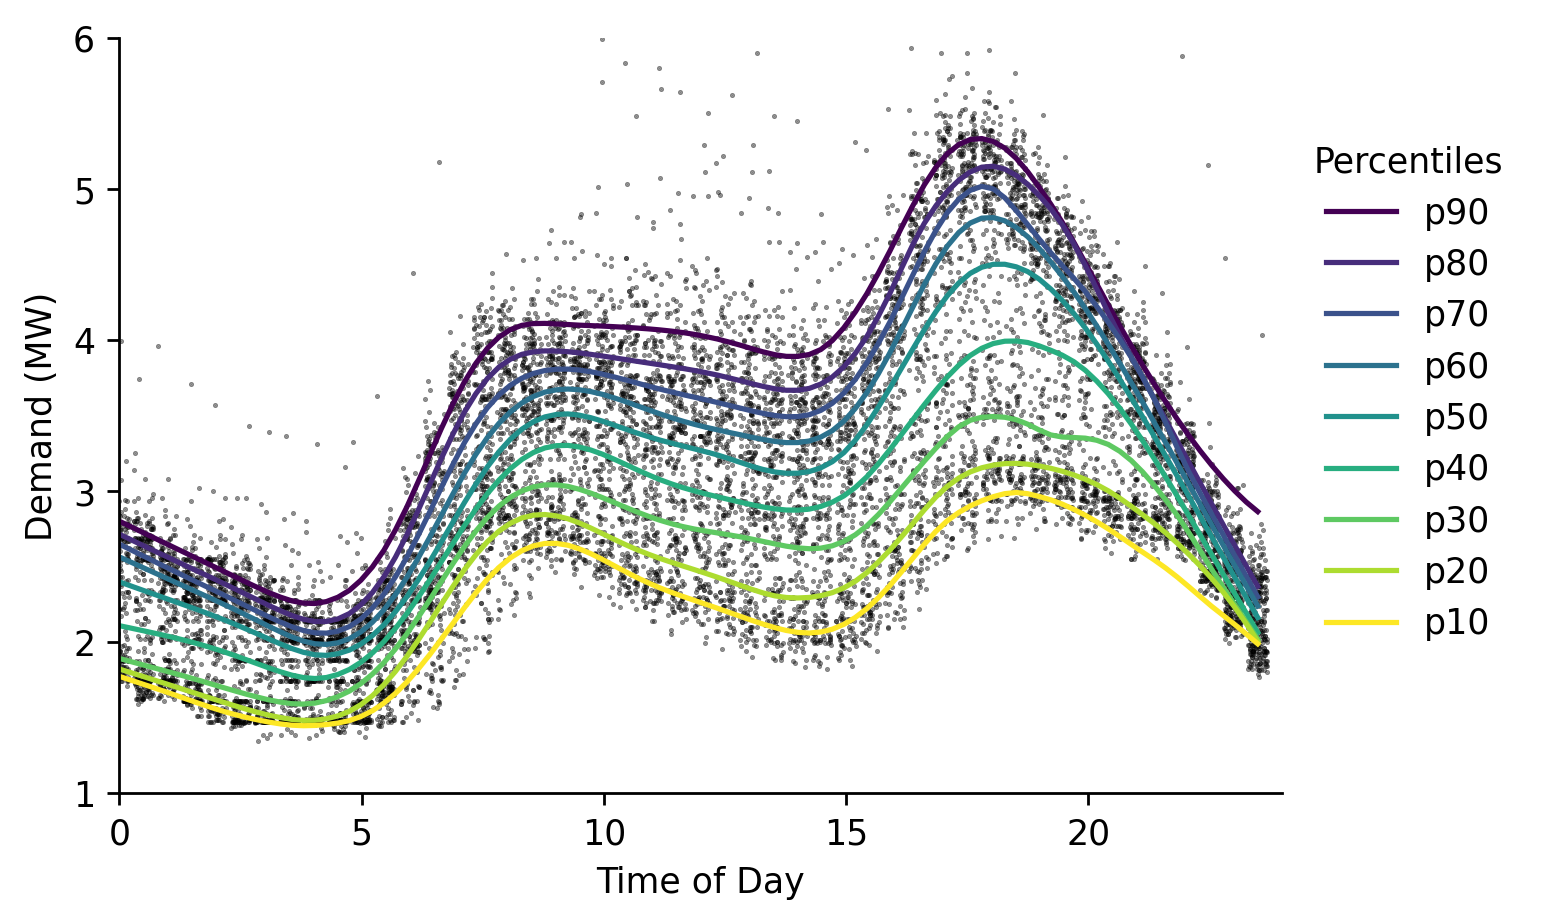

In [10]:
x_jittered = x + (np.random.uniform(size=len(x)) - 0.5)/2.5

# Plotting
fig, ax = plt.subplots(dpi=250)

ax.scatter(x_jittered, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.9), title='Percentiles')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(1, 6)

fig.savefig('../img/daily_demand_profile.png')

<br>

One of the issues with the quantile fit is that it hides the a lot of the spikiness in individual daily profiles, here we'll create a function for randomly sampling days so we can visualise them alongside each other.

In [11]:
#exports
reset_idx_dt = lambda s, dt='2020-01-01': s.index - (s.index[0]-pd.to_datetime(dt, utc=True))

def sample_random_day(s):
    random_dt = random.choice(s.index.date)
    s_sample_dt = s.loc[str(random_dt)]
    
    return s_sample_dt

def sample_random_days(s, num_days=5):
    df_sample_dts = pd.DataFrame()

    for _ in range(num_days):
        s_sample_dt = sample_random_day(s)
        dt = str(s_sample_dt.index[0].date())
        s_sample_dt.index = reset_idx_dt(s_sample_dt)
        df_sample_dts[dt] = s_sample_dt
        
    df_sample_dts = df_sample_dts.sort_index(axis=1)

    return df_sample_dts

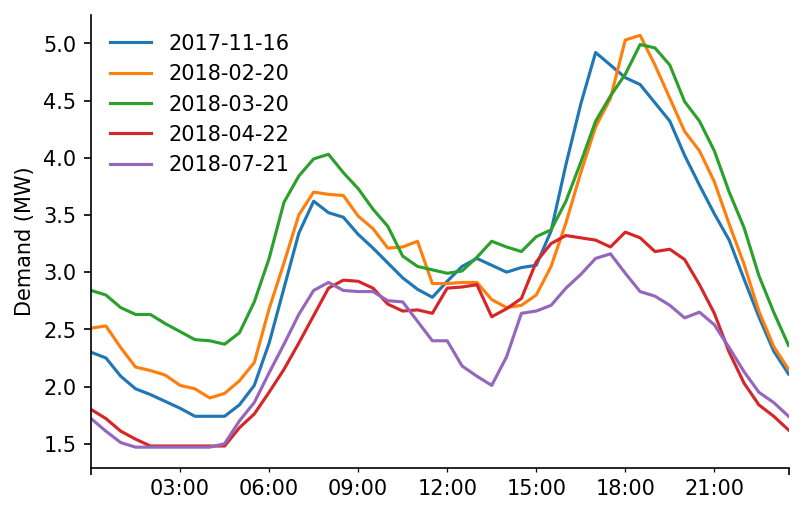

In [12]:
df_sample_dts = sample_random_days(s_demand)
    
# Plotting
fig, ax = plt.subplots(dpi=150)

df_sample_dts.plot(ax=ax)

ax.legend(frameon=False)
hlp.hide_spines(ax)
ax.set_xlabel('')
ax.set_ylabel('Demand (MW)')

_ = plt.setp(ax.get_xmajorticklabels(), visible=False)

<br>

We'll also check the auto-correlation of the demand time-series, particularly in regard to the the correlation of the most recent value with the value from one week prior (what will be available for the test data)

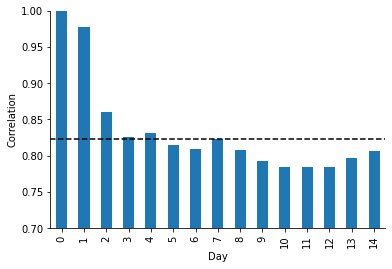

In [13]:
acf_array = acf(s_demand, fft=True, nlags=48*7*2)

day_blocks = [0] + list(np.array([[i+1]*48 for i in range(14)]).reshape(-1))
s_acf_days_max = pd.Series(acf_array).groupby(day_blocks).max()
corr_with_last_weeks_SP = s_acf_days_max.loc[7]

# Plotting
fig, ax = plt.subplots()

s_acf_days_max.plot.bar(ax=ax)
ax.plot([-0.5, 14.5], [corr_with_last_weeks_SP, corr_with_last_weeks_SP], 'k--')

ax.set_ylim(0.7, 1)
ax.set_xlabel('Day')
ax.set_ylabel('Correlation')
hlp.hide_spines(ax)

In [14]:
# We cant yet do a seasonal decomposition using statsmodels (requires 2 years of data)
# Once it is possible we should though

In [15]:
# could use public holiday data and see what influence that has
# for the covid period may need to add a rolling covid factor as a feature (could be last_week_reduction_pct relative to previous year)

<br>

We'll also fit a quantile model for the relationship between temperature and demand

In [16]:
x = df[df.columns[df.columns.str.contains('temp_location')]].mean(axis=1).values
y = df['demand_MW'].values

rerun_temp_demand_model = False
temp_demand_filename = 'temp_demand_quantile_model_results.csv'

if (rerun_temp_demand_model == True) or (temp_demand_filename not in os.listdir(cache_data_dir)):
    df_quantiles = estimate_daily_demand_quantiles(x, y, frac=0.35, num_fits=48, robust_iters=5)
    df_quantiles.to_csv(f'{cache_data_dir}/{temp_demand_filename}')
else:
    df_quantiles = pd.read_csv(f'{cache_data_dir}/{temp_demand_filename}', index_col='x')

df_quantiles.head()

,p90,p80,p70,p60,p50,p40,p30,p20,p10
x,,,,,,,,,
0.000000,4.979148,4.542691,4.219802,3.872879,3.374841,2.901714,2.709592,2.596514,2.460552
0.237374,4.967268,4.522081,4.202166,3.860984,3.370116,2.893770,2.697211,2.581770,2.444861
0.474747,4.955148,4.501440,4.184532,3.849105,3.365557,2.885883,2.684999,2.567177,2.429250
0.712121,4.942842,4.480709,4.166860,3.837254,3.361100,2.877872,2.672848,2.552647,2.413687
0.949495,4.930293,4.459841,4.149140,3.825419,3.356739,2.869692,2.660735,2.538161,2.398162


<br>

Which we'll visualise similarly to the daily demand profile

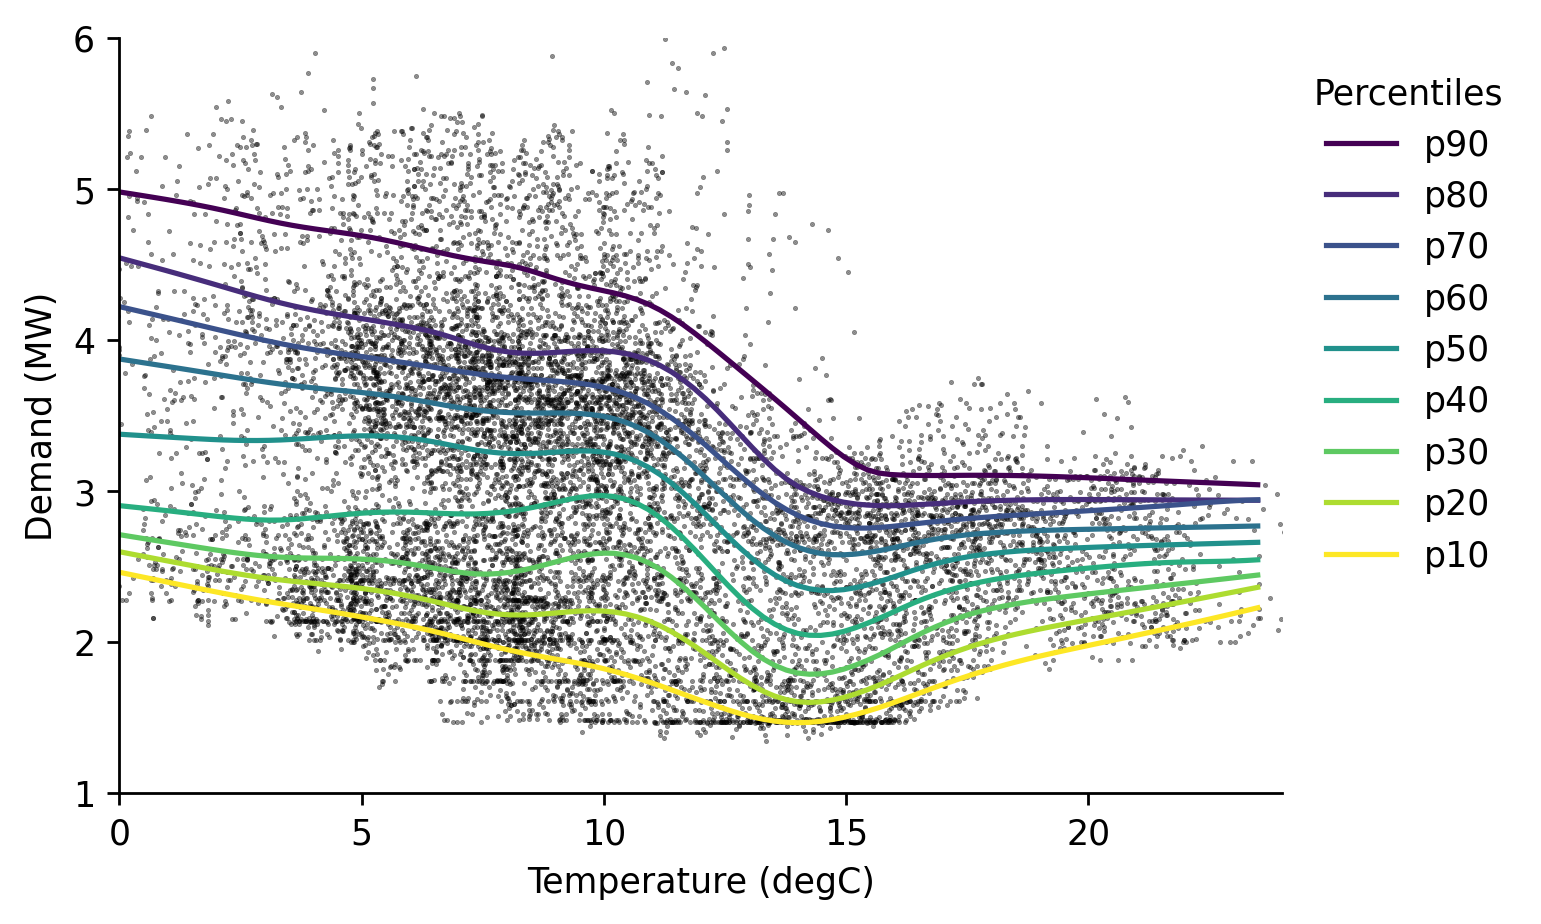

In [17]:
fig, ax = plt.subplots(dpi=250)

ax.scatter(x, y, s=0.2, color='k', alpha=0.5)
df_quantiles.plot(cmap='viridis', legend=False, ax=ax)

hlp.hide_spines(ax)
ax.legend(frameon=False, bbox_to_anchor=(1, 0.25), title='Percentiles')
ax.set_xlabel('Temperature (degC)')
ax.set_ylabel('Demand (MW)')
ax.set_xlim(0, 24)
ax.set_ylim(1, 6)

fig.savefig('../img/temp_demand_profile.png')

In [18]:
# ^ Should use daily average (or evening block) instead of each SP

<br>

### Strategy Development with Perfect Foresight

Here we'll develop a charging strategy for when we have perfect foresight, starting by sampling a random day from the demand series and then extracting the evening profile as an array from that

In [19]:
#exports
def extract_evening_demand_profile(s_demand_sample_dt, start_time='15:30', end_time='20:30'):
    dt = str(s_demand_sample_dt.index[0].date())
    evening_demand_profile = s_demand_sample_dt[f'{dt} {start_time}':f'{dt} {end_time}'].values

    return evening_demand_profile

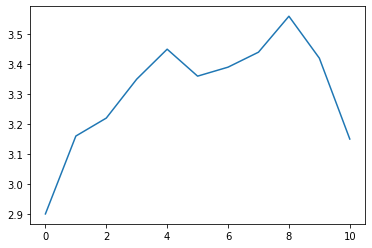

In [20]:
evening_demand_profile = sample_random_day(s_demand).pipe(extract_evening_demand_profile)

plt.plot(evening_demand_profile)

<br>

We'll then write an algorithm for peak flattening

In [21]:
#exports
def flatten_peak(evening_demand_profile, charge=6, time_unit=0.5):
    peak = max(evening_demand_profile)
    adj_evening_demand_profile = evening_demand_profile.copy()

    while charge > 0:
        num_periods_plateaued = (evening_demand_profile>=peak).sum()

        # If the evening demand profile has been fully flattened
        # then split up the remaining charge equally across all SPs
        fully_flattened = len(set(adj_evening_demand_profile)) == 1

        if fully_flattened == True:
            remaining_discharge_rate_for_each_SP = (1/time_unit)*charge/len(adj_evening_demand_profile)
            adj_evening_demand_profile -= remaining_discharge_rate_for_each_SP
            charge = 0
            break

        # If there is still a peak then determine the next highest value 
        else:
            peak = max(adj_evening_demand_profile)
            highest_non_peak = max(adj_evening_demand_profile[peak>adj_evening_demand_profile])

            proposed_additional_discharge = time_unit*(adj_evening_demand_profile.sum() - np.minimum(adj_evening_demand_profile, highest_non_peak).sum())

        # if its possible to reduce the peak to the next highest value do so
        if charge >= proposed_additional_discharge:
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, highest_non_peak)
            charge -= proposed_additional_discharge

        # If the capacity constraints are broken when reducing to the next 
        # highest value then just lower the current peak as far as possible
        else:
            new_peak = peak - ((1/time_unit)*charge/(num_periods_plateaued+1))
            adj_evening_demand_profile = np.minimum(adj_evening_demand_profile, new_peak)
            charge = 0

    return adj_evening_demand_profile

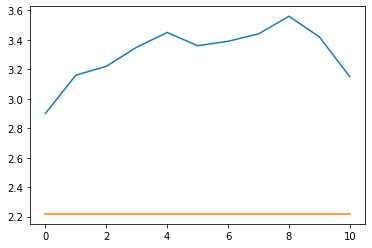

In [22]:
adj_evening_demand_profile = flatten_peak(evening_demand_profile)

plt.plot(evening_demand_profile)
plt.plot(adj_evening_demand_profile)

<br>

Which we can deduct from the original evening profile to construct the discharge profile

In [23]:
#exports
construct_discharge_profile = lambda evening_demand_profile, adj_evening_demand_profile: -(evening_demand_profile - adj_evening_demand_profile)

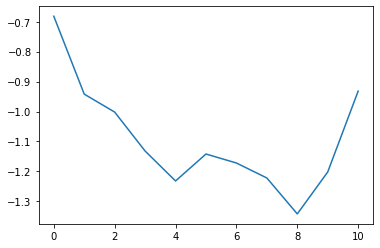

In [24]:
discharge_profile = construct_discharge_profile(evening_demand_profile, adj_evening_demand_profile)

plt.plot(discharge_profile)

<br>

Rather than the sample day we've just used we'll now repeat this step for all days we have demand data on, returning a series of the new discharge values that can be easily added to the charging values

In [25]:
#exports
def construct_discharge_s(s_demand, start_time='15:30', end_time='20:30'):
    s_discharge = pd.Series(index=s_demand.index, dtype=float).fillna(0)

    for dt in s_demand.index.strftime('%Y-%m-%d').unique():
        evening_demand_profile = s_demand[dt].pipe(extract_evening_demand_profile)
        adj_evening_demand_profile = flatten_peak(evening_demand_profile)
        
        discharge_profile = construct_discharge_profile(evening_demand_profile, adj_evening_demand_profile)
        s_discharge[f'{dt} {start_time}':f'{dt} {end_time}'] = discharge_profile

    return s_discharge

<AxesSubplot:>

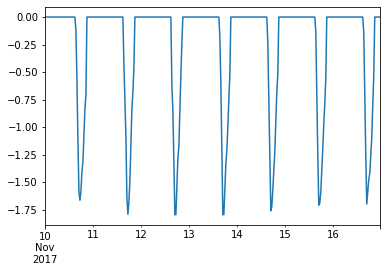

In [26]:
s_discharge = construct_discharge_s(s_demand, start_time='15:30', end_time='20:30')

s_discharge.iloc[:48*7].plot()

<br>

We can also use this discharging profile to see what the new peaks look like

<AxesSubplot:>

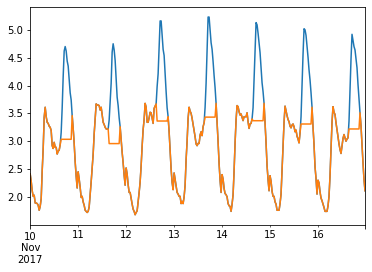

In [27]:
s_demand.iloc[:48*7].plot()
(s_demand+s_discharge).iloc[:48*7].plot()

<br>

### Strategy Development under Uncertainty

Our overall approach can be thought of as follows:

1. Generate an optimal discharge profile under perfect foresight
2. Train a regression model to emulate the optimal discharge profile
3. Clean profile to ensure that constraints aren't broken and the full 6 MWh is fully utilised

We've generated our optimal discharge profile, now we're ready to train the model. We'll first split up our X and y values, filtering only for those that fall into the evening period

In [28]:
#exports
def extract_evening_datetimes(df):
    hour = df.index.hour + df.index.minute/60
    evening_datetimes = df.index[(20.5>=hour) & (15.5<=hour)]
    
    return evening_datetimes

In [29]:
evening_datetimes = extract_evening_datetimes(df_features)

X = df_features.loc[evening_datetimes].values
y = s_discharge.loc[evening_datetimes].values

<br>

We'll create a basic prediction using a standard linear model

In [30]:
df_pred = clean.generate_kfold_preds(X, y, LinearRegression(), index=evening_datetimes)

df_pred.head()

,pred,true
2017-11-10 15:30:00+00:00,-0.704354,-0.125455
2017-11-10 16:00:00+00:00,-0.778424,-0.565455
2017-11-10 16:30:00+00:00,-0.935294,-1.125455
2017-11-10 17:00:00+00:00,-1.129670,-1.585455
2017-11-10 17:30:00+00:00,-1.168337,-1.665455


<br>

However, in this approach there's nothing to enforce the battery constraints, namely maximum total discharge and instantaneous discharge rate. This becomes apparant when we visualise the distribution of total discharge volumes each evening.

C:\Users\Ayrto\anaconda3\envs\batopt\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pred', ylabel='Density'>

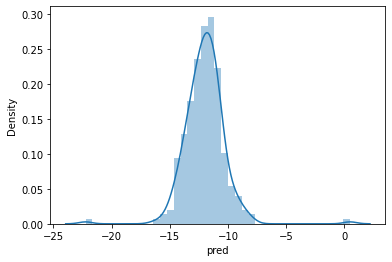

In [31]:
s_daily_discharge = df_pred['pred'].groupby(df_pred.index.date).sum()

sns.distplot(s_daily_discharge)

<br>

To account for this we can normalise each daily discharge profile by the ratio between the current total discharge and the maximum current discharge

In [32]:
#exports
def normalise_total_discharge(s_pred, charge=6, time_unit=0.5):
    s_daily_discharge = s_pred.groupby(s_pred.index.date).sum()

    for date, total_discharge in s_daily_discharge.items():
        s_pred.loc[str(date)] *= -charge/(time_unit*total_discharge)
        
    return s_pred

In [33]:
s_daily_discharge = (df_pred
                     ['pred']
                     .pipe(normalise_total_discharge)
                     .groupby(df_pred.index.date)
                     .sum()
                     .round(10)
                    )

s_daily_discharge.value_counts()

-12.0    255
Name: pred, dtype: int64

<br>

We also need to ensure that the discharge rate remains within the bounds of the problem definition, i.e. no greater than -2.5 MW

In [34]:
#exports
clip_discharge_rate = lambda s_pred, max_rate=-2.5, min_rate=0: s_pred.clip(lower=max_rate, upper=min_rate)

In [35]:
s_pred = df_pred['pred'].pipe(clip_discharge_rate)

s_pred.head()

2017-11-10 15:30:00+00:00   -0.784678
2017-11-10 16:00:00+00:00   -0.867195
2017-11-10 16:30:00+00:00   -1.041954
2017-11-10 17:00:00+00:00   -1.258496
2017-11-10 17:30:00+00:00   -1.301574
Name: pred, dtype: object

<br>

We'll now combine these post prediction processing steps into a single function, ready to use in our model evaluation

**Note that the normalisation must come after the clipping. Otherwise the total charge constraint can be violated if the model predicts a discharge > 0**

In [36]:
#exports
# post_pred_proc_func = lambda s_pred: (s_pred
#                                       .pipe(normalise_total_discharge)
#                                       .pipe(clip_discharge_rate)
#                                      )
post_pred_proc_func = lambda s_pred: (s_pred
                                      .pipe(clip_discharge_rate)
                                      .pipe(normalise_total_discharge)
                                     )

In [37]:
post_pred_proc_func(s_pred).groupby(s_pred.index.date).sum().value_counts()

-12.0    156
-12.0     37
-12.0     25
-12.0     16
-12.0     14
-12.0      5
-12.0      1
-12.0      1
Name: pred, dtype: int64

<br>

We'll create a new function that evaluates our discharge profile in terms of the peak reduction achieved relative the reduction using an optimal discharge profile. We'll then use this and our standard mae and rmse metrics to evaluate some different models.

In [38]:
#exports
def construct_peak_reduction_calculator(s_demand, evening_datetimes=None, scorer=False):
    if evening_datetimes is None:
        evening_datetimes = extract_evening_datetimes(s_demand)
            
    def calc_peak_reduction(y, y_pred):
        # Checking evening datetimes
        if hasattr(y_pred, 'index') == True:
            evening_datetimes = extract_evening_datetimes(y_pred)
            
        assert y_pred.shape[0] == s_demand.loc[evening_datetimes].shape[0], f'The prediction series must be the same length as the number of evening datetimes in the main dataframe, {y_pred.shape[0]} {s_demand.loc[evening_datetimes].shape[0]}'

        # Identifying daily peaks
        s_old_peaks = s_demand.loc[evening_datetimes].groupby(evening_datetimes.date).max()
        s_new_peaks = (s_demand.loc[evening_datetimes]+y_pred).groupby(evening_datetimes.date).max()
        s_optimal_peaks = (s_demand.loc[evening_datetimes]+y).groupby(evening_datetimes.date).max()

        # Calculating the peak reduction
        s_new_pct_peak_reduction = 100*(s_old_peaks-s_new_peaks)/s_old_peaks
        s_optimal_pct_peak_reduction = 100*(s_old_peaks-s_optimal_peaks)/s_old_peaks

        # after cleaning anomalous demand data should add an assert to check for non finite values

        pct_of_max_possible_reduction = 100*(s_new_pct_peak_reduction.replace(np.inf, np.nan).dropna().mean()/
                                             s_optimal_pct_peak_reduction.replace(np.inf, np.nan).dropna().mean())

        return pct_of_max_possible_reduction

    if scorer == True:
        return make_scorer(calc_peak_reduction)
    else:
        return calc_peak_reduction

def evaluate_discharge_models(df, models, features_kwargs={}):
    df_features = construct_df_discharge_features(df, **features_kwargs)
    s_discharge = construct_discharge_s(df['demand_MW'], start_time='15:30', end_time='20:30')
    
    evening_datetimes = extract_evening_datetimes(df_features)
    
    X = df_features.loc[evening_datetimes].values
    y = s_discharge.loc[evening_datetimes].values
    
    model_scores = dict()
    peak_reduction_calc = construct_peak_reduction_calculator(s_demand=df['demand_MW'], evening_datetimes=evening_datetimes)
    
    for model_name, model in track(models.items()):
        df_pred = clean.generate_kfold_preds(X, y, model, index=evening_datetimes)
        df_pred['pred'] = post_pred_proc_func(df_pred['pred'])

        model_scores[model_name] = {
            'pct_optimal_reduction': peak_reduction_calc(df_pred['true'], df_pred['pred']),
            'optimal_discharge_mae': mean_absolute_error(df_pred['true'], df_pred['pred']),
            'optimal_discharge_rmse': np.sqrt(mean_squared_error(df_pred['true'], df_pred['pred']))
        }

    df_model_scores = pd.DataFrame(model_scores)
    
    df_model_scores.index.name = 'metric'
    df_model_scores.columns.name = 'model'
    
    return df_model_scores

In [39]:
models = {
    'std_linear': LinearRegression(),
    'random_forest': RandomForestRegressor(),
    'boosted': GradientBoostingRegressor()
}

rerun_discharge_opt_model = False
discharge_opt_filename = 'discharge_optimisation_model_results.csv'

if (rerun_discharge_opt_model == True) or (discharge_opt_filename not in os.listdir(cache_data_dir)):
    df_model_scores = evaluate_discharge_models(df, models)
    df_model_scores.to_csv(f'{cache_data_dir}/{discharge_opt_filename}')
else:
    df_model_scores = pd.read_csv(f'{cache_data_dir}/{discharge_opt_filename}', index_col='metric')

df_model_scores

,std_linear,random_forest,boosted
metric,,,
pct_optimal_reduction,79.137163,87.820045,86.579210
optimal_discharge_mae,0.212580,0.094955,0.106689
optimal_discharge_rmse,0.275607,0.126610,0.138982


<br>

We'll then generate a prediction time-series using the best performing model

In [40]:
rerun_discharge_pred_model = False
discharge_pred_filename = 'discharge_optimisation_model_pred.csv'

if (rerun_discharge_pred_model == True) or (discharge_pred_filename not in os.listdir(cache_data_dir)):
    top_model = df_model_scores.T['pct_optimal_reduction'].idxmax()
    df_pred = clean.generate_kfold_preds(X, y, models[top_model], index=evening_datetimes)
    df_pred['pred'] = post_pred_proc_func(df_pred['pred'])
    df_pred.to_csv(f'{cache_data_dir}/{discharge_pred_filename}')
else:
    df_pred = pd.read_csv(f'{cache_data_dir}/{discharge_pred_filename}')
    df_pred['datetime'] = pd.to_datetime(df_pred['datetime'], utc=True)
    df_pred = df_pred.set_index('datetime')
    
df_pred.head()

,pred,true
datetime,,
2017-11-10 15:30:00+00:00,-0.213378,-0.125455
2017-11-10 16:00:00+00:00,-0.735541,-0.565455
2017-11-10 16:30:00+00:00,-1.194376,-1.125455
2017-11-10 17:00:00+00:00,-1.577044,-1.585455
2017-11-10 17:30:00+00:00,-1.614260,-1.665455


<br>

We'll quickly check the residuals time-series for model-drift

<AxesSubplot:xlabel='datetime'>

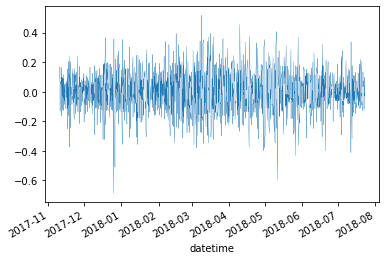

In [41]:
s_residuals = df_pred.diff(1, axis=1).dropna(axis=1).iloc[:, 0]

s_residuals.plot(linewidth=0.3)

<br>

As well as the scatter-plot between the true and estimated optimal charging rates

Text(0, 0.5, 'Prediction')

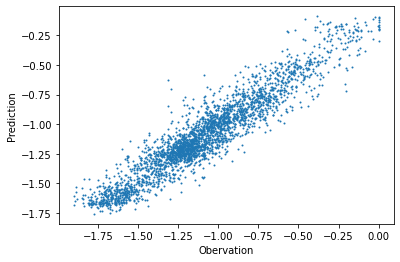

In [42]:
plt.scatter(df_pred['true'], df_pred['pred'], s=1)

plt.xlabel('Obervation')
plt.ylabel('Prediction')

<br>

### Feature Selection

In [43]:
# use mlxtend to select the relevant features

<br>

### Hyper-Parameter Tuning

In [44]:
evening_datetimes = extract_evening_datetimes(df_features)
peak_reduction_scorer = construct_peak_reduction_calculator(s_demand=df['demand_MW'], 
                                                            evening_datetimes=evening_datetimes, 
                                                            scorer=True)

X = df_features.loc[evening_datetimes]
y = s_discharge.loc[evening_datetimes]
groups = evening_datetimes.date

pipeline = Pipeline([
    ('pandas_RF', utils.PandasRandomForestRegressor())
])

search_spaces = {
        'pandas_RF__min_samples_leaf': Integer(1, 20, 'uniform'),
        'pandas_RF__criterion': Categorical(['mse', 'mae']),
        'pandas_RF__n_estimators': Integer(200, 2000, 'uniform'),
        'pandas_RF__max_features': Categorical(['auto', 'sqrt']),
        'pandas_RF__max_depth': Integer(10, 110, 'uniform'),
        'pandas_RF__min_samples_split': Integer(2, 10, 'uniform'),
        'pandas_RF__min_samples_leaf': Integer(1, 4, 'uniform'),
        'pandas_RF__bootstrap': Categorical([True, False])
}

opt = utils.BayesSearchCV(
    pipeline,
    search_spaces,
    n_iter=20,
    verbose=1,
    cv=8, # 8 works well for me as that's how many concurrent workers I can use
    scoring=peak_reduction_scorer,
    n_jobs=-1
)

fit_BayesSearchCV = False

if fit_BayesSearchCV == True:
    opt.fit(X, y, groups=groups)

    print(f'validation score: {opt.best_score_}')
    print(f'test score: {opt.score(X, y)}')
    print(f'best params: {opt.best_params_}')

    _ = plot_objective(opt.optimizer_results_[0])
    plt.show()

In [45]:
# should save the best params in a JSON file and then load from then if not running the full optimisation

In [46]:
%%time

model_params = {
    'criterion': 'mse',
    'max_depth': 10,
    'min_samples_leaf': 4,
    'min_samples_split': 2,
    'n_estimators': 100
}

model = RandomForestRegressor(**model_params)

df_pred = clean.generate_kfold_preds(X.values, y.values, model, index=evening_datetimes)
peak_reduction_calc = construct_peak_reduction_calculator(s_demand=df['demand_MW'], evening_datetimes=evening_datetimes)
pct_optimal_reduction = peak_reduction_calc(df_pred['true'], df_pred['pred'])

pct_optimal_reduction

Wall time: 4.04 s


87.43043348200621

<br>

### Pipeline Integration Helpers

In [49]:
#exports
def prepare_training_input_data(intermediate_data_dir):
    # Loading input data
    df = clean.combine_training_datasets(intermediate_data_dir).interpolate(limit=1)
    df_features = construct_df_discharge_features(df)
    
    # Filtering for overlapping feature and target data
    dt_idx = pd.date_range(df_features.index.min(), df['demand_MW'].dropna().index.max()-pd.Timedelta(minutes=30), freq='30T')

    s_demand = df.loc[dt_idx, 'demand_MW']
    df_features = df_features.loc[dt_idx]
    
    # Constructing the discharge series
    s_discharge = construct_discharge_s(s_demand, start_time='15:30', end_time='20:30')
    
    # Filtering for evening datetimes
    evening_datetimes = extract_evening_datetimes(df_features)
    
    X = df_features.loc[evening_datetimes]
    y = s_discharge.loc[evening_datetimes]
    
    return X, y

In [50]:
X, y = prepare_training_input_data(intermediate_data_dir)

X.shape, y.shape

((2805, 11), (2805,))

In [51]:
#exports
def fit_and_save_model(X, y, discharge_opt_model_fp, model_class=RandomForestRegressor, **model_params):
    model = model_class(**model_params)
    model.fit(X, y)
    
    with open(discharge_opt_model_fp, 'wb') as fp:
        joblib.dump(model, fp)
        
    return

In [52]:
%%time

fit_and_save_model(X, y, discharge_opt_model_fp, **model_params)

Wall time: 979 ms


In [53]:
#exports
def load_trained_model(discharge_opt_model_fp):
    with open(discharge_opt_model_fp, 'rb') as fp:
        model = joblib.load(fp)
    
    return model

In [54]:
%%time

model = load_trained_model(discharge_opt_model_fp)

model

Wall time: 40 ms


RandomForestRegressor(max_depth=10, min_samples_leaf=4)

In [70]:
#exports
def load_latest_submission_template(raw_data_dir, latest_submission_template_name=None):    
    if latest_submission_template_name is None:
        latest_submission_template_name = max([filename for filename in os.listdir(raw_data_dir) if 'teamname_set' in filename])
    
    df_submission_template = pd.read_csv(f'{raw_data_dir}/{latest_submission_template_name}')
    
    df_submission_template['datetime'] = pd.to_datetime(df_submission_template['datetime'], utc=True)
    df_submission_template = df_submission_template.set_index('datetime')
    
    return df_submission_template

def prepare_latest_test_feature_data(raw_data_dir, intermediate_data_dir, latest_submission_template_name=None):
    # Loading input data
    df_features = (clean
                   .combine_training_datasets(intermediate_data_dir)
                   .interpolate(limit=1)
                   .pipe(construct_df_discharge_features)
                  )
    
    df_submission_template = load_latest_submission_template(raw_data_dir, latest_submission_template_name=latest_submission_template_name)
    
    # Filtering feature data on submission datetimes
    df_features = df_features.loc[df_submission_template.index]
    
    return df_features

In [71]:
df_features = prepare_latest_test_feature_data(raw_data_dir, intermediate_data_dir)

df_features.head()

,temp_location1,temp_location2,temp_location3,temp_location4,temp_location5,temp_location6,demand_7d_lag,weekend,hour,doy,dow
datetime,,,,,,,,,,,
2018-07-23 00:00:00+00:00,16.74,17.050,15.67,17.860,18.740,18.500,1.73,0,1.0,204,0
2018-07-23 00:30:00+00:00,16.62,16.845,15.57,17.585,18.630,18.355,1.62,0,1.5,204,0
2018-07-23 01:00:00+00:00,16.50,16.640,15.47,17.310,18.520,18.210,1.56,0,2.0,204,0
2018-07-23 01:30:00+00:00,16.41,16.485,15.37,17.050,18.455,18.110,1.48,0,2.5,204,0
2018-07-23 02:00:00+00:00,16.32,16.330,15.27,16.790,18.390,18.010,1.48,0,3.0,204,0


In [91]:
#exports
def optimise_latest_test_discharge_profile(raw_data_dir, intermediate_data_dir, discharge_opt_model_fp, latest_submission_template_name=None):
    df_features = prepare_latest_test_feature_data(raw_data_dir, intermediate_data_dir, latest_submission_template_name=latest_submission_template_name)
    evening_datetimes = extract_evening_datetimes(df_features)
    X_test = df_features.loc[evening_datetimes].values
    
    model = load_trained_model(discharge_opt_model_fp)
    discharge_profile = model.predict(X_test)
    
    s_discharge_profile = pd.Series(discharge_profile, index=evening_datetimes)
    s_discharge_profile = s_discharge_profile.reindex(df_features.index).fillna(0)
    
    return s_discharge_profile

<AxesSubplot:xlabel='datetime'>

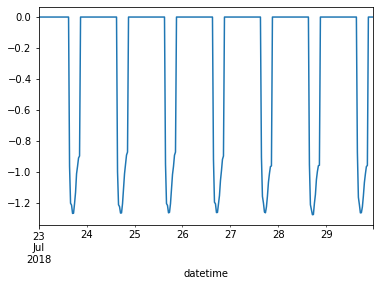

In [92]:
s_discharge_profile = optimise_latest_test_discharge_profile(raw_data_dir, intermediate_data_dir, discharge_opt_model_fp)

s_discharge_profile.plot()

<br>

Finally we'll export the relevant code to our `batopt` module

In [94]:
#hide
from nbdev.export import notebook2script
    
notebook2script()

Converted 00-utilities.ipynb.
Converted 01-data-cleaning.ipynb.
Converted 02-battery-discharge.ipynb.
Converted 03-battery-charge.ipynb.
Converted 03-pv-forecast.ipynb.
Converted 04-battery-optimisation.ipynb.
Converted 05-evaluation.ipynb.
Converted 06-pipeline.ipynb.
